# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

Name(s): Arunuday Ganju,Akash Nanndi

Student Number(s): 18204644,17200206

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

#from TAS_Python_Utilities import data_viz
#from TAS_Python_Utilities import data_viz_target
#from TAS_Python_Utilities import visualize_tree

import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
import itertools
warnings.filterwarnings("ignore")

%matplotlib inline
#%qtconsole

In [2]:
# making dictionaries to store test accuracy and cohens kappa score for comparison
model_test_accuracy_comparisons = dict()
model_cohenskappa_comparisons = dict()

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [3]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [4]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [5]:
# setting the sampling rate to select a part of the whole data 
data_sampling_rate = 0.01

In [6]:

dataset = pd.read_csv('fashion-mnist_train.csv') 
dataset = dataset.groupby('label').apply(lambda x: x.sample(frac=data_sampling_rate))# reading mnist train fashion dataset
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
label                                                                        
0     8795       0       0       0       0       0       0       0       0   
      4469       0       0       0       0       0       1       0       0   
      33407      0       0       0       0       0       0       0       0   
      41513      0       0       0       0       0       1       0       0   
      56228      0       0       0       0       0       0       0       0   

             pixel8  pixel9  ...  pixel775  pixel776  pixel777  pixel778  \
label                        ...                                           
0     8795        0       4  ...         0         0         0         0   
      4469        0       1  ...       111       100       158        16   
      33407       0       0  ...         7         0         0         0   
      41513       0       0  ...       163       154       182         0   
      56228       0       0  ...        46        47        50         0   

             pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
label                                                                    
0     8795          0         0         0         0         0         0  
      4469          0         3         0         0         0         0  
      33407         0         0         0         0         0         0  
      41513         0         1         0         0         0         0  
      56228         0         1         0         0         0         0  

[5 rows x 785 columns]

In [7]:
X = dataset[dataset.columns[1:]]  # X contains the feature set
y = np.array(dataset["label"])    # y contains the target set

In [8]:
X=X/255  # normalizing the feature set

In [9]:
model= StackedEnsembleClassifier() 
model.fit(X,y)    # fitting the modle using StackedEnsembleClassifier()

StackedEnsembleClassifier(base_estimator_duplicates=8,
                          base_estimator_types=['svm', 'logreg', 'tree'],
                          stack_layer_classifier_type='logreg')

In [10]:
dataset_test= pd.read_csv('fashion-mnist_test.csv')  # reading mnist test dataset
num_classes=10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}



In [11]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255 # normalizing the test features
#y_pred = model.predict(test_X)

In [12]:
y_pred = model.predict(test_X) # evaluating the value of predicted target outsomes

In [13]:
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred)) # displaying the accuracy.metric

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7878
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1000
           1       0.93      0.94      0.93      1000
           2       0.66      0.72      0.69      1000
           3       0.81      0.82      0.81      1000
           4       0.70      0.68      0.69      1000
           5       0.87      0.82      0.85      1000
           6       0.56      0.45      0.50      1000
           7       0.82      0.82      0.82      1000
           8       0.93      0.94      0.93      1000
           9       0.85      0.92      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.78      0.79      0.79     10000
weighted avg       0.78      0.79      0.79     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,769,12,26,66,3,6,98,1,19,0,1000
1,13,937,10,33,3,1,3,0,0,0,1000
2,7,5,721,8,121,2,119,0,17,0,1000
3,64,29,16,818,39,0,33,0,1,0,1000
4,7,8,181,36,682,2,81,0,3,0,1000
5,2,0,1,0,0,821,1,117,4,54,1000
6,213,10,123,46,130,3,447,0,28,0,1000
7,0,0,0,0,0,70,0,819,1,110,1000
8,1,4,10,1,3,7,18,12,942,2,1000


In [14]:
# evaluating the cohens kappa score which can be used for  comparing the performance of different classifiers
normal_cohen= cohen_kappa_score(test_Y, y_pred)  
normal_accuracy= str(accuracy)                       
model_cohenskappa_comparisons["StackedEnsembleClassifier"]=normal_cohen # adding the kappa sore in the respective dictionary as a key-value pair
model_test_accuracy_comparisons["StackedEnsembleClassifier"]=normal_accuracy # adding the accuracy in the respective dictionary as a key-value pair

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [16]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## Task 1: Design the StackedEnsembleHoldOut Class

In [17]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg", hold_value=0.3):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.hold_value=hold_value #The value for holdout split the training data

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= self.hold_value, random_state=0)  #Splitting the training data into training and test data 70-30
        # Store the classes seen during fit
        self.classes_ = unique_labels(y_train)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X_train)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        

        # Use all training data to train base classifiers
        #X_train = X
        #y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test # Using the test data from holdout to train the model
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_test) # Using X_test instead of X_train for predicting probabilities of class

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [18]:
X = dataset[dataset.columns[1:]]  # X contains the feature set
y = np.array(dataset["label"])  # y contains the target set

In [19]:
X=X/255 # normalizing the feature set

In [20]:
model= StackedEnsembleClassifierHoldOut()
model.fit(X,y) # Fitting the model for StackedEnsembleClassifierHoldOut


StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                                 base_estimator_types=['svm', 'logreg', 'tree'],
                                 hold_value=0.3,
                                 stack_layer_classifier_type='logreg')

In [21]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255 # normalizing the feature set
#y_pred = model.predict(test_X)

In [22]:
y_pred = model.predict(test_X)

In [23]:
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7541
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1000
           1       0.96      0.93      0.94      1000
           2       0.66      0.53      0.58      1000
           3       0.77      0.85      0.80      1000
           4       0.63      0.65      0.64      1000
           5       0.82      0.82      0.82      1000
           6       0.40      0.40      0.40      1000
           7       0.82      0.79      0.80      1000
           8       0.93      0.91      0.92      1000
           9       0.85      0.93      0.89      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,744,7,8,84,2,7,127,1,20,0,1000
1,5,927,1,37,0,0,30,0,0,0,1000
2,19,2,525,4,167,8,261,0,14,0,1000
3,61,22,7,847,16,2,42,0,3,0,1000
4,8,6,157,74,654,3,96,0,2,0,1000
5,1,0,0,2,0,824,4,115,6,48,1000
6,228,3,97,52,195,6,400,0,19,0,1000
7,0,0,0,0,0,99,0,785,0,116,1000
8,2,3,4,7,5,18,38,12,910,1,1000


In [24]:
# evaluating the cohens kappa score which can be used for  comparing the performance of different classifiers
holdout_cohen= cohen_kappa_score(test_Y, y_pred)
holdout_accuracy= str(accuracy)
model_cohenskappa_comparisons["StackedEnsembleClassifierHoldOut"]=holdout_cohen
model_test_accuracy_comparisons["StackedEnsembleClassifierHoldOut"]=holdout_accuracy

## Task 2: Design the StackedEnsembleKFold Class

In [25]:
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types=["svm", "logreg", "tree"], base_estimator_duplicates=8, stack_layer_classifier_type="logreg", cv_folds=3):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.cv_folds = cv_folds # Passing the value of folds to be performed

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X) * 0.05 / self.cv_folds))
                classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(classifiers_)

        # Use all training data to train base classifiers
        #X_train = X
        #y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = np.array([]) # Initially passing an empty array to to the y_stack_train
        
        #Create Stratified KFold splits
        skf = StratifiedKFold(n_splits=self.cv_folds)
        skf.get_n_splits(X, y)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_stack_train = None
            try:
                self.y_stack_train = np.r_[self.y_stack_train, y_test]
            except ValueError:
                self.y_stack_train = y_test
            #print(self.y_stack_train)

            # Train each base classifier and generate the stack layer training
            # dataset
            for classifier in classifiers_:

                # Extract a bootstrap sample from the training set
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
                # Train a base classifier using the bootstrapped training set
                classifier.fit(X_train_samp, y_train_samp)
            
                # Make predictions for all instances in the hold out test set
                y_pred = classifier.predict_proba(X_test)

                # Append the predictions of the stack layer training set (a bit of hacking here!)
                try:
                    X_stack_train = np.c_[X_stack_train, y_pred]
                except ValueError:
                    X_stack_train = y_pred
            try:
                self.X_stack_train = np.r_[self.X_stack_train, X_stack_train]
            except ValueError:
                self.X_stack_train = X_stack_train
            
        # Set up the base classifeirs in the ensemble for later prediction
        self.classifiers_ = list()
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X) * 0.05))
                # Extract a bootstrap sample from the full dataset
                X_train_samp, y_train_samp = resample(X, y, replace=True)    
                # Train a base classifier using the bootstrapped set
                c.fit(X_train_samp, y_train_samp)
                self.classifiers_.append(c)

        #########################
        ## LEVEL 1
        #########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X) * 0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query
    # instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_
        # dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the
        # training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack
        # layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query
    # instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_
        # dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the
        # training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
            
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)


In [26]:
X = dataset[dataset.columns[1:]] # X contains the feature set
y = np.array(dataset["label"]) # y contains the target set

In [27]:
X=X/255 #normalizing the values to a common base

dataset_test= pd.read_csv('fashion-mnist_test.csv')

In [28]:
model= StackedEnsembleClassifierKFold() # Default value for cv_folds is 5



In [29]:
model.fit(X,y)# Fitting the model for StackedEnsembleClassifierKFold

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                               base_estimator_types=['svm', 'logreg', 'tree'],
                               cv_folds=3,
                               stack_layer_classifier_type='logreg')

In [30]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255

In [31]:
y_pred = model.predict(test_X) # Predict on the test set 

In [32]:
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7669
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1000
           1       0.93      0.95      0.94      1000
           2       0.60      0.69      0.64      1000
           3       0.82      0.83      0.82      1000
           4       0.63      0.69      0.66      1000
           5       0.84      0.86      0.85      1000
           6       0.43      0.27      0.33      1000
           7       0.84      0.78      0.81      1000
           8       0.93      0.93      0.93      1000
           9       0.85      0.91      0.88      1000

    accuracy                           0.77     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.76      0.77      0.76     10000

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,758,10,29,72,8,3,99,1,20,0,1000
1,11,954,6,15,3,0,11,0,0,0,1000
2,17,3,689,6,139,3,128,0,15,0,1000
3,45,36,10,826,34,0,47,0,2,0,1000
4,4,9,194,34,687,3,67,0,2,0,1000
5,1,0,0,1,0,862,3,95,4,34,1000
6,232,6,204,41,216,4,273,0,24,0,1000
7,0,0,0,0,0,89,0,782,0,129,1000
8,3,3,12,8,9,8,13,13,929,2,1000


In [33]:
# evaluating the cohens kappa score which can be used for  comparing the performance of different classifiers
kfold_cohen=cohen_kappa_score(test_Y, y_pred)
kfold_accuracy= str(accuracy)
model_cohenskappa_comparisons["StackedEnsembleClassifierKFold"]=kfold_cohen
model_test_accuracy_comparisons["StackedEnsembleClassifierKFold"]=kfold_accuracy
print(kfold_cohen)

0.7409999999999999


## Task 3: Compare the Performance of Different Stack Layer Approaches

In [34]:
names2 = list(model_cohenskappa_comparisons.keys()) # Storing the key values in a variable
values2 = list(model_cohenskappa_comparisons.values()) # SToring the value of the keys in a variable


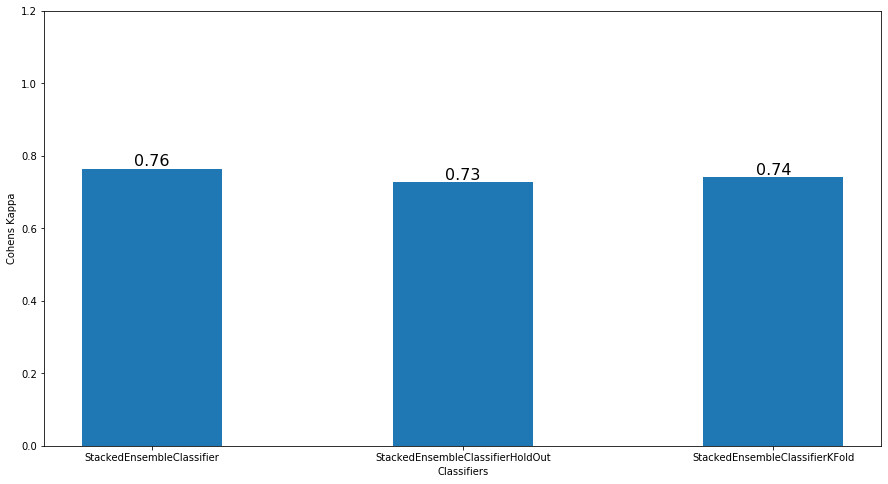

In [35]:
plt.figure(figsize=(15,8))
plt.xlabel('Classifiers')
plt.ylabel('Cohens Kappa')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)
bar_width=0.45
bar1=plt.bar(range(len(model_cohenskappa_comparisons)),values2,bar_width,tick_label=names2)
i=0
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(values2[i],2)), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()

In [36]:
names3 = list(model_test_accuracy_comparisons.keys())

values3 =[float(i) for i in list(model_test_accuracy_comparisons.values())]

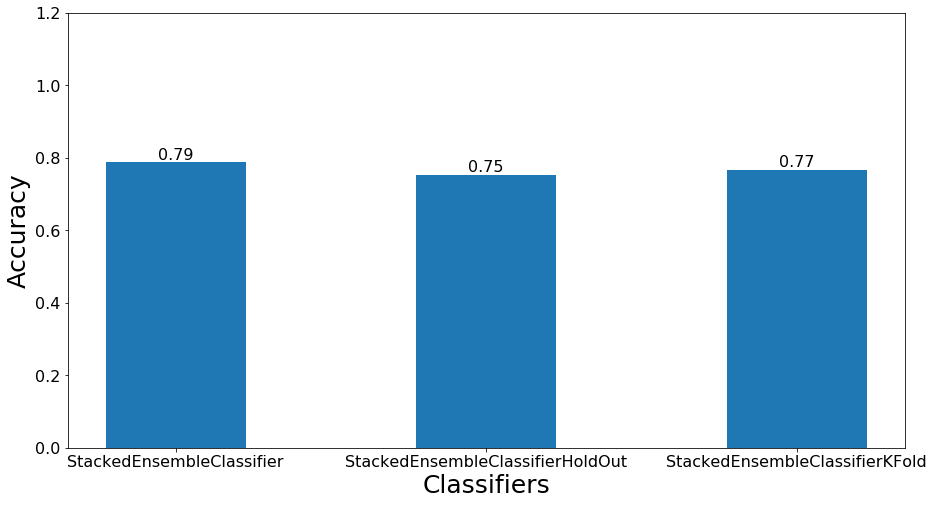

In [37]:
plt.figure(figsize=(15,8))
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)

for items in values3:
    str(items)

bar_width=0.45
bar1=plt.bar(range(len(model_test_accuracy_comparisons)),values3,bar_width,tick_label=names3)
i=0

[float(i) for i in list(model_test_accuracy_comparisons.values())]
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(float(values3[i]),2)), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()


### After comparing the accuracies and cohens kappa of all the 3 classifiers we see that the Kfold has a slightly better performce against the HoldOut class as there is more variety and diversity when training the model with Kfold which in turn gives a better performance

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

### Performance of a simple Decision tree with Grid search

In [38]:
X = dataset[dataset.columns[1:]]
y = np.array(dataset["label"])
X=X/255

In [39]:
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [math.ceil(len(X)*0.05)]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=5, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X, y)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=3, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=3, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=3, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=3, min_samples_split=30, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=30 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=30, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=3, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=30 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_split=30 ...............
[CV]  

[CV]  criterion=gini, max_depth=39, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=39, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=39, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=39, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=39, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=39, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=39, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=42, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=42, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=42, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=42, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=42, min_samples_split=30 ..............
[CV]  criterion=gini, max_depth=42, min_samples_split=30, total=   0.1s
[CV] criterion=gini, max_depth=42, min_samples_split=30 ..............

[CV]  criterion=entropy, max_depth=24, min_samples_split=30, total=   0.2s
[CV] criterion=entropy, max_depth=27, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=27, min_samples_split=30, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=27, min_samples_split=30, total=   0.2s
[CV] criterion=entropy, max_depth=27, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=27, min_samples_split=30, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=27, min_samples_split=30, total=   0.2s
[CV] criterion=entropy, max_depth=27, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=27, min_samples_split=30, total=   0.1s
[CV] criterion=entropy, max_depth=30, min_samples_split=30 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=30, total=   0.1s
[CV] criterion=entropy, max_depth=30, min_samples

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   20.0s finished


{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 30}

0.6433333333333333

{'mean_fit_time': array([0.05359826, 0.08237357, 0.09225845, 0.09738736, 0.10109205,
        0.10908742, 0.11408043, 0.11531358, 0.10226936, 0.09791346,
        0.0972198 , 0.09657569, 0.09635944, 0.09481363, 0.09649434,
        0.09412675, 0.09231458, 0.15018854, 0.14940848, 0.15203767,
        0.15779028, 0.15341678, 0.14968328, 0.1493516 , 0.14850945,
        0.14823699, 0.14813852, 0.14992404, 0.14960656, 0.15706644,
        0.14859514, 0.14860711]),
 'std_fit_time': array([0.00551344, 0.00218489, 0.00623987, 0.00746732, 0.00577038,
        0.01579311, 0.00513686, 0.00665508, 0.01014823, 0.00810368,
        0.00920664, 0.00584019, 0.00579806, 0.00454744, 0.00836597,
        0.00498488, 0.00245376, 0.00642734, 0.00554336, 0.00326708,
        0.00977303, 0.00853561, 0.00618178, 0.0035288 , 0.00576049,
        0.00305699, 0.00470934, 0.00349608, 0.00720212, 0.0071417 ,
        0.00574144, 0.00248282]),
 'mean_score_time': array([0.00114336, 0.0011241 , 0.00114775, 0.00121365, 0.001145

In [40]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255


In [41]:
y_pred = my_tuned_tree.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None

print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6511
              precision    recall  f1-score   support

           0       0.83      0.60      0.69      1000
           1       0.91      0.89      0.90      1000
           2       0.73      0.50      0.59      1000
           3       0.54      0.79      0.64      1000
           4       0.55      0.56      0.56      1000
           5       0.60      0.73      0.66      1000
           6       0.34      0.51      0.41      1000
           7       0.75      0.66      0.70      1000
           8       0.81      0.63      0.71      1000
           9       0.82      0.65      0.73      1000

    accuracy                           0.65     10000
   macro avg       0.69      0.65      0.66     10000
weighted avg       0.69      0.65      0.66     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,598,20,18,130,8,4,205,2,12,3,1000
1,0,886,1,89,1,2,21,0,0,0,1000
2,6,22,496,7,171,4,257,1,32,4,1000
3,12,19,5,790,26,16,129,0,1,2,1000
4,0,7,42,99,557,2,287,0,4,2,1000
5,0,1,0,26,0,728,20,142,40,43,1000
6,107,17,85,109,137,4,512,1,27,1,1000
7,0,0,0,47,0,201,0,662,8,82,1000
8,0,3,27,134,102,13,52,34,633,2,1000


In [42]:
decisiontree_cohen= cohen_kappa_score(test_Y, y_pred)
decisiontree_accuracy= str(accuracy)
model_cohenskappa_comparisons["Decision Tree"]=decisiontree_cohen
model_test_accuracy_comparisons["Decision Tree"]=decisiontree_accuracy

### Performance of a ensemble based on Bagging using Grid Search

In [43]:
X = dataset[dataset.columns[1:]]
y = np.array(dataset["label"])
X=X/255

In [44]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(5, 50, 5)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 30)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=2, verbose = 2)
my_tuned_model.fit(X, y)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=5 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=5, total=   0.1s
[CV] base_estimator=DecisionTreeClassif

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=5, total=   0.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=10 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=30, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=35 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   11.3s finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 30}
0.5816666666666667


In [45]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255


In [46]:
y_pred = my_tuned_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.678
              precision    recall  f1-score   support

           0       0.61      0.75      0.68      1000
           1       0.91      0.87      0.89      1000
           2       0.59      0.64      0.62      1000
           3       0.68      0.66      0.67      1000
           4       0.50      0.82      0.62      1000
           5       0.70      0.62      0.66      1000
           6       0.47      0.01      0.01      1000
           7       0.74      0.73      0.74      1000
           8       0.81      0.81      0.81      1000
           9       0.70      0.88      0.78      1000

    accuracy                           0.68     10000
   macro avg       0.67      0.68      0.65     10000
weighted avg       0.67      0.68      0.65     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,752,13,80,90,17,2,3,2,41,0,1000
1,5,867,25,85,7,5,0,0,4,2,1000
2,40,7,638,1,283,0,2,0,29,0,1000
3,133,38,35,660,92,12,1,0,5,24,1000
4,22,14,62,58,818,2,2,0,22,0,1000
5,4,3,0,0,0,616,0,189,15,173,1000
6,263,11,189,65,393,1,7,0,71,0,1000
7,0,0,0,0,0,147,0,730,1,122,1000
8,4,1,44,11,35,25,0,17,809,54,1000


In [47]:
bagging_cohen= cohen_kappa_score(test_Y, y_pred)
bagging_accuracy= str(accuracy)
model_cohenskappa_comparisons["Bagging"]=bagging_cohen
model_test_accuracy_comparisons["Bagging"]=bagging_accuracy

In [48]:
names4 = list(model_test_accuracy_comparisons.keys())

values4 =[float(i) for i in list(model_test_accuracy_comparisons.values())]

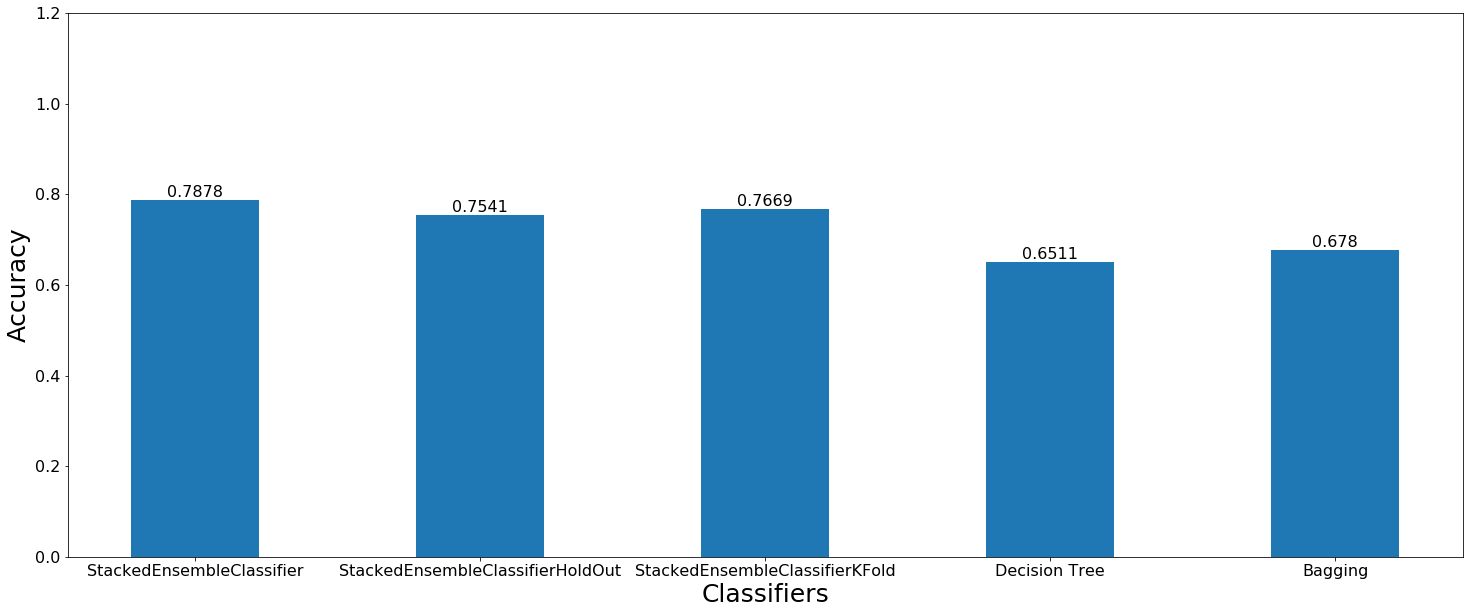

In [49]:
plt.figure(figsize=(25,10))
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)



bar_width=0.45
bar1=plt.bar(range(len(model_test_accuracy_comparisons)),values4,bar_width,tick_label=names4)
i=0

[float(i) for i in list(model_test_accuracy_comparisons.values())]
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(float(values4[i]),6)), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()



In [50]:
names5 = list(model_cohenskappa_comparisons.keys()) # Storing the key values in a variable
values5 = list(model_cohenskappa_comparisons.values()) # SToring the value of the keys in a variable

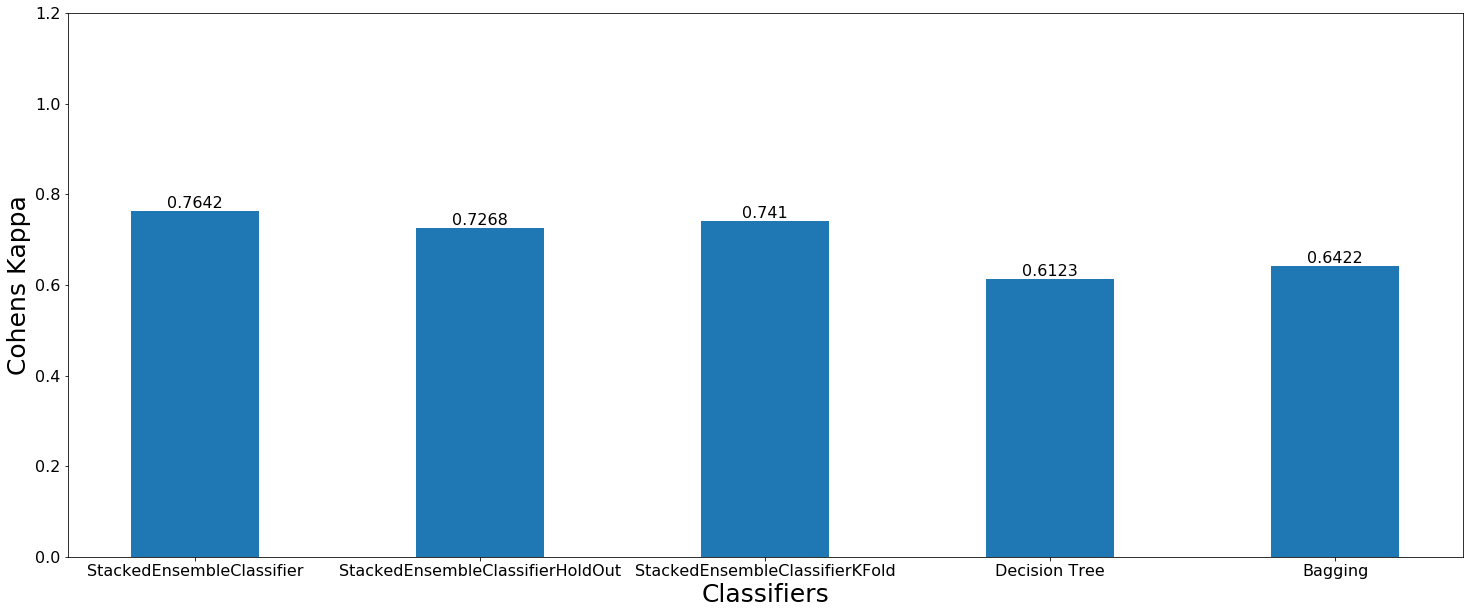

In [51]:
plt.figure(figsize=(25,10))
plt.xlabel('Classifiers')
plt.ylabel('Cohens Kappa')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)
bar_width=0.45
bar1=plt.bar(range(len(model_cohenskappa_comparisons)),values5,bar_width,tick_label=names5)
i=0
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(values5[i],4)), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()

### <div style="text-align: justify">After comparing the accuracies and cohens kappa of all the 3 classifiers along with decision tree and bagging ensemble we see that the Kfold has a slightly better performce against the HoldOut class as there is more variety and diversity when training the model with Kfold which in turn gives a better performance. The performance of Decision tree and Bagging seems to be lower after using grid search and selecting the best parameters.</div>

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [52]:
class StackedEnsembleClassifierOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["logreg"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg", hold_value=0.3):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.hold_value=hold_value

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        fulldata = X.copy()
        if (type(fulldata) != pd.core.frame.DataFrame):
            fulldata = pd.DataFrame(fulldata)
        fulldata['label'] = y.tolist()
        print(self.base_estimator_duplicates)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
                
                
        spec_no = list(itertools.combinations(self.classes_ , 2)) # Create a list of the class combinations(Eg: (0,1), (0,2), (1,2) in case of iris dataset)
        for i in range(0, self.base_estimator_duplicates):         # Lopping through the nuber of duplicates for resampling
            for k,j in spec_no:
               
                
                a=(fulldata[(fulldata['label']==k) | (fulldata['label']==j)]) #creating a dataset containing data and classes of only (i,j)
                X_train= a[a.columns[1:]]   #splitting the dataset into features
                y_train= np.array(a["label"])  # splitting the dataset into class labels

                for t in self.base_estimator_types:
                    self.base_estimator_type_list.append(t)      
                    c = create_classifier(t)
                    self.classifiers_.append(c)

                    # Extract a bootstrap sample
                    X_train_samp, y_train_samp = resample(X_train, y_train, replace=True) # Passing the value of X_train and y_train for class i and j 

                    # Train a base classifier
                    c.fit(X_train_samp, y_train_samp)

                    # Make predictions for all instances in the training set
                    d = c.predict_proba(X)  # Passing the whole training data for calculating probalities
                    y_pred = d
                    # Append the predictions ot the stack layer traing set 
                    try:
                        self.X_stack_train = np.c_[self.X_stack_train, y_pred] # Passing in y_pred to the next layer and stacking it column wise
                    except ValueError:
                        self.X_stack_train = y_pred    
                    
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        

        # Use all training data to train base classifiers
        #X_train = X
        #y_train = y
          
        # Train each base calssifier and generate the stack layer training dataset
        
        
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))
        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)



In [53]:
X = dataset[dataset.columns[1:]] # X contains all the feature values
y = np.array(dataset["label"]) # y contains all the target values

In [54]:
X=X/255 # Normalizing the feature set

In [55]:
model= StackedEnsembleClassifierOneVsOne()
model.fit(X,y)# Fitting the model for StackedEnsembleClassifierOneVsOne

8


StackedEnsembleClassifierOneVsOne(base_estimator_duplicates=8,
                                  base_estimator_types=['logreg'],
                                  hold_value=0.3,
                                  stack_layer_classifier_type='logreg')

In [56]:
test_X = dataset_test[dataset_test.columns[1:]]
test_Y = np.array(dataset_test["label"])

test_X=test_X/255
y_pred = model.predict(test_X)

In [57]:
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7527
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1000
           1       0.85      0.86      0.85      1000
           2       0.65      0.64      0.64      1000
           3       0.76      0.76      0.76      1000
           4       0.64      0.72      0.68      1000
           5       0.91      0.78      0.84      1000
           6       0.44      0.33      0.38      1000
           7       0.82      0.80      0.81      1000
           8       0.93      0.94      0.93      1000
           9       0.81      0.94      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,756,23,11,73,4,3,110,1,18,1,1000
1,18,856,22,80,0,0,24,0,0,0,1000
2,14,7,640,7,179,1,139,0,13,0,1000
3,71,83,9,764,19,0,46,0,8,0,1000
4,4,21,137,42,721,0,71,0,3,1,1000
5,6,0,0,1,0,781,1,124,6,81,1000
6,237,15,156,35,202,2,329,0,24,0,1000
7,0,0,0,0,0,58,0,803,0,139,1000
8,3,4,11,2,5,5,23,6,939,2,1000


In [58]:
OneVsOne_cohen=cohen_kappa_score(test_Y, y_pred)
OneVsOne_accuracy= str(accuracy)
model_cohenskappa_comparisons["StackedEnsembleClassifierOneVsOne"]=OneVsOne_cohen
model_test_accuracy_comparisons["StackedEnsembleClassifierOneVsOne"]=OneVsOne_accuracy


## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

In [59]:
# Write your code here
print(model_cohenskappa_comparisons)

{'StackedEnsembleClassifier': 0.7642222222222221, 'StackedEnsembleClassifierHoldOut': 0.7267777777777777, 'StackedEnsembleClassifierKFold': 0.7409999999999999, 'Decision Tree': 0.6123333333333332, 'Bagging': 0.642222222222222, 'StackedEnsembleClassifierOneVsOne': 0.7252222222222222}


In [60]:
print(model_test_accuracy_comparisons)

{'StackedEnsembleClassifier': '0.7878', 'StackedEnsembleClassifierHoldOut': '0.7541', 'StackedEnsembleClassifierKFold': '0.7669', 'Decision Tree': '0.6511', 'Bagging': '0.678', 'StackedEnsembleClassifierOneVsOne': '0.7527'}


In [61]:
names = list(model_cohenskappa_comparisons.keys())
values = list(model_cohenskappa_comparisons.values())


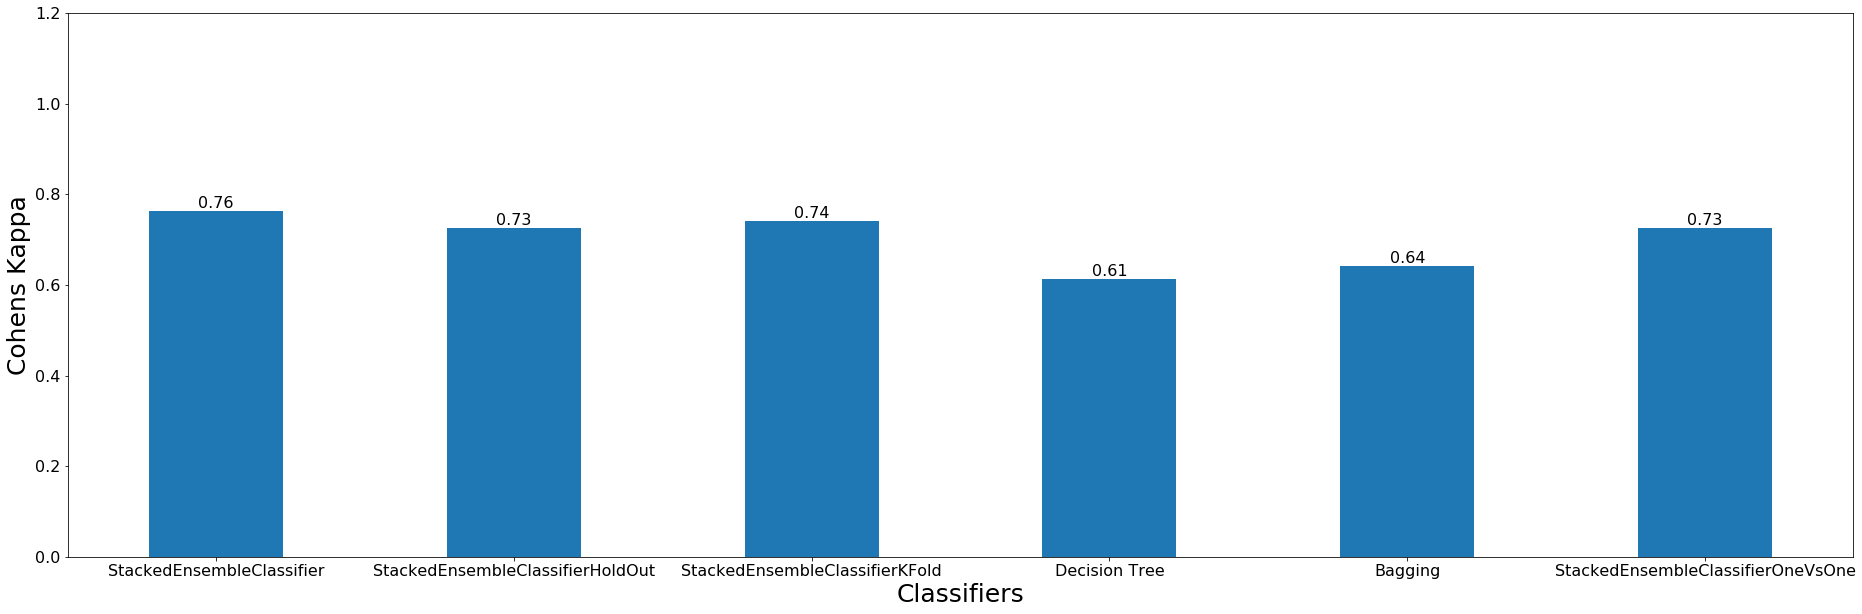

In [62]:
plt.figure(figsize=(32,10))
plt.xlabel('Classifiers')
plt.ylabel('Cohens Kappa')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)


bar_width=0.45
bar1=plt.bar(range(len(model_cohenskappa_comparisons)),values,bar_width,tick_label=names)
i=0
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(values[i],2)), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()

In [63]:
names1 = list(model_test_accuracy_comparisons.keys())
#values1 = list(model_test_accuracy_comparisons.values())
values1 = [float(i) for i in list(model_test_accuracy_comparisons.values())]


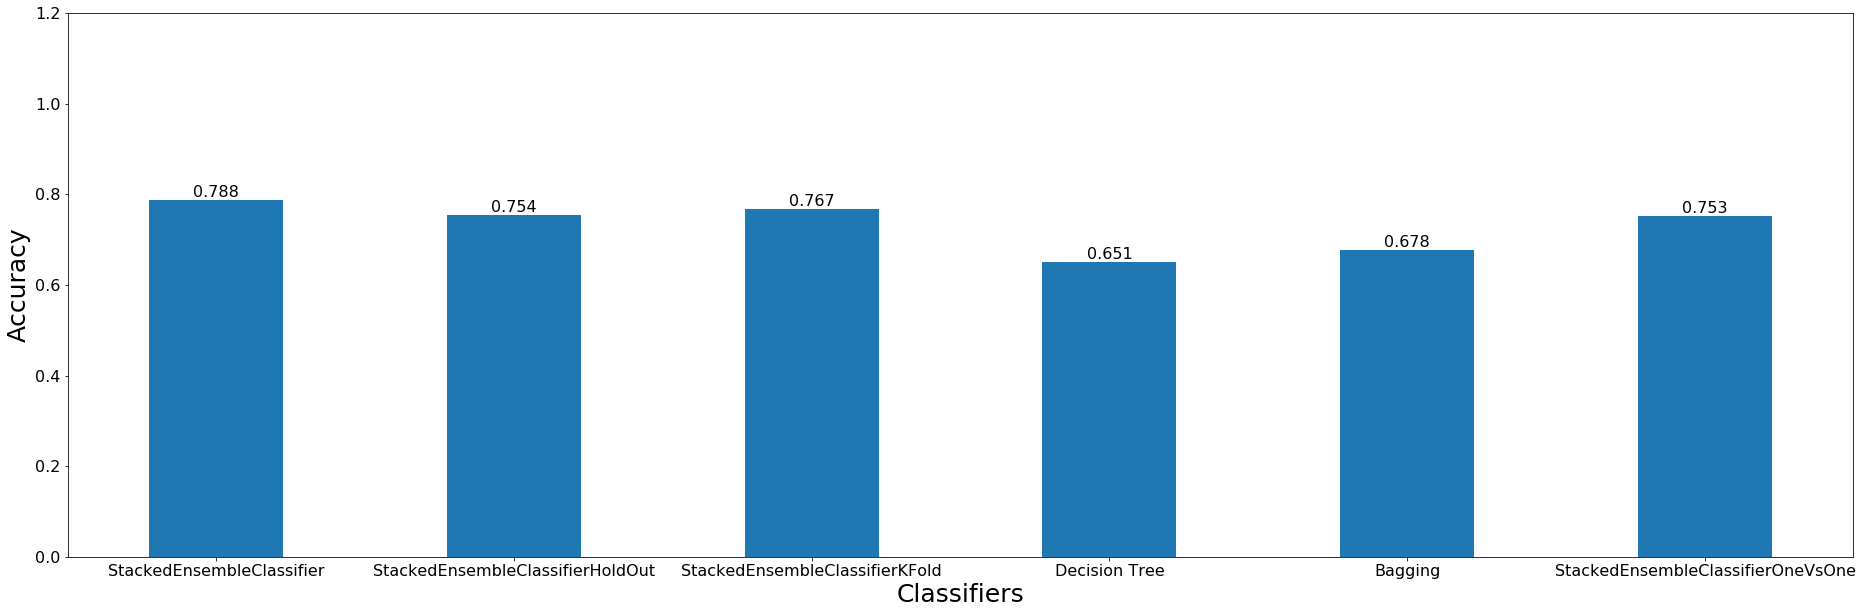

In [64]:
plt.figure(figsize=(32,10))
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.rc('axes',labelsize=25)
plt.rc('font', size=16)
bar_width=0.45
bar2=plt.bar(range(len(model_test_accuracy_comparisons)),values1,bar_width,tick_label=names1)
i=0
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, round(float(values1[i]),3), ha='center', va='bottom')
    i+=1
plt.ylim(ymax=1.2)
plt.show()

### <div style="text-align: justify">After comparing the accuracies and cohens kappa of all the 3 classifiers along with decision tree and bagging ensemble we see that the Kfold has a slightly better performce against the HoldOut class as there is more variety and diversity when training the model with Kfold which in turn gives a better performance. The performance of Decision tree and Bagging seems to be lower after using grid search and selecting the best parameters. The performance of OneVsOne classifier is the lowest among all the other stacked layer classifiers</div>

## Task 7 Reflect on the Performance of the Different Models Evaluated


### Mentioned below are 4 critical points which describes the above classifiers performance:

###  <div style="text-align: justify"> 1. Above we have implemented the StackedEnsembleClassifierHoldOut , the StackedEnsembleClassifierKFold and the StackedEnsembleClassifierOneVsOne. For training the model we have used sampling rate of 0.01 in every classifier to maintain uniformity. From the above performance comparison using classification report, accuracy and cohens kappa score we observe that the KFold perfoms the best among the HoldOut and OneVsOne classifier since Kfold generates more variety and each fold gets duplicated 8 times, along with resampling which results in more diverse data for training and hence a better training model is formulated leading to improved accuracy. Decision tree and bagging used with grid search are observed to have lower accuracy  even with the best params seclected from the range given.</div>
### <div style="text-align: justify">2. In OneVSOne the method of ensembles consisting of specialist classifiers is incorporated. Each specialist classifies two classes e.g. 0, 1 thus 45 such classifiers are trained to classify each pair target classes from the Mnist-Fashion dataset.</div>
### <div style="text-align: justify">3. For StackedEnsembleClassifierHoldOut, StackedEnsembleClassifierKFold models we used heterogenous ensembles with 24 base classifiers using a mixture of decision trees, support vector machines and logistic regression models. The next best accuracy that we observe is for HoldOut where an hold-out test set is kept as the training dataset for the stack layer. </div>
### 4. We used logreg and decision tree for the stack layer and found out that we got better results in performance for logreg while the accuracy dipped when we used decision trees.